# Initiallize
Import libraries and functions provided by nix or conda environment

In [1]:
# Initiallization
import tkinter as tk
from tkinter import filedialog
import glob
from natsort import natsorted
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

# Functions
Basic functions for pipeline

## File operation
Get File structure & read files

In [2]:
# Read and combine .csv files into a single dataframe
def combine_csv(folder_path, filtering_pattern):
    csv_file_paths = natsorted(glob.glob(os.path.join(folder_path, filtering_pattern)))

    matrices = []
    for file in csv_file_paths:
        mat = np.loadtxt ( file, delimiter=',', skiprows=3, usecols=(1,2,3) ) # Read and skip the first three rows of metadata, use 2nd, 3rd, 4th cloumn for the first point
        matrices.append(mat)
    if len(matrices) == 0:
        raise ValueError("No matching data found for the given pattern.")
    combined_matrix = np.vstack ( matrices ) # Combine the data into a combined matrix

    df = pd.DataFrame(combined_matrix, columns=['xPix', 'yPix', 'likelihood'])

    df['frameNum'] = df.index + 1
    
    return df

In [3]:
def read_timestamp(folder_path, filename):
    df_ts = pd.read_csv(os.path.join(folder_path, filename), sep='\t').drop(columns=['buffer'])
    df_ts.loc[0, 'sysClock'] = 0
    df_ts['timeSec'] = df_ts['sysClock'] / 1000
    df_ts = df_ts.drop(columns=['sysClock'])

    return df_ts

## Time and space converting
Convert timestamp/framenumber and pixels in video to real-world time and distance

In [4]:
# Converting pixel coordinate to real world coordinate

def space_convert(df, pixelX, pixelY, actualX, actualY):
    df['x'] = df['xPix'] / pixelX * actualX
    df['y'] = df['yPix'] / pixelY * actualY
    return df

In [5]:
# Directly suggest time by frame number, for hai's project

def framerate_convert(df, frame_rate):
    df['timeSec'] = df.index / frame_rate
    return df

In [6]:
def timestamp_convert(df, df_ts, camera_number):
    df_cam_ts = df_ts[df_ts['camNum'] == camera_number].reset_index(drop=True)

    merged_df = df_cam_ts.merge(
        df[['frameNum', 'xPix', 'yPix', 'likelihood']],
        on='frameNum',
        how='left'
    )
    
    # Replace NaNs in unmached lines with 0 for prediction
    merged_df['xPix'] = merged_df['xPix'].fillna(0)
    merged_df['yPix'] = merged_df['yPix'].fillna(0)
    merged_df['likelihood'] = merged_df['likelihood'].fillna(0)
    
    return merged_df

## Frame operations
Delete or add frames as needed

In [7]:
# For Hai's project with exactly same redundant frames
def drop_redundant_frames(df):
    cols = ['x', 'y']
    mask = (df[cols] == df[cols].shift(1)).all(axis=1)
    return df[~mask].reset_index(drop=True)

In [8]:
# For fixing Wirefree miniscope's messy dual camera 3D imaging
def insert_lost_frames(df):
    new_rows = []
    
    for i in range(len(df)-1):

        current_cam = df.iloc[i]['camNum']
        next_cam = df.iloc[i + 1]['camNum']

        current_row = df.iloc[i].copy()
        new_rows.append(current_row)

        if current_cam != next_cam:
            continue

        new_cam = 1 if current_cam == 0 else 0
                
        last_matching_row = None
        for j in range(i, -1, -1):
            if df.iloc[j]['camNum'] == new_cam:
                last_matching_row = df.iloc[j]
                break
                
        next_matching_row = None
        for j in range(i + 1, len(df)):
            if df.iloc[j]['camNum'] == new_cam:
                next_matching_row = df.iloc[j]
                break
                
        new_row = current_row.copy()
        new_row['camNum'] = new_cam
        new_row['frameNum'] = -1
                
        if last_matching_row is not None and next_matching_row is not None:
            # change the sysClock assign rule
            new_row['timeSec'] = (last_matching_row['timeSec'] + next_matching_row['timeSec']) / 2
        else:
            new_row['timeSec'] = current_row['timeSec']
                
        new_rows.append(new_row)
    
    new_df = pd.DataFrame(new_rows)
    
    new_df = new_df.reset_index(drop=True)
    
    return new_df

## Data filter
Add "toPredict" tag to the inserted frames or frames that needs to be deleted

In [9]:
def tag_likelihood(df, threshold):
    df.loc[df['likelihood'] >= threshold, 'toPredict'] = 0
    df.loc[df['likelihood'] < threshold, 'toPredict'] = 1
    return df

In [10]:
def tag_inserted(df, threshold):
    df.loc[df['frameNum'] == -1, 'toPredict'] = 1
    return df

In [11]:
def tag_overspeed(df, threshold):
    df.loc[df['speed'] >= threshold, 'toPredict'] = 1
    return df

## Predict algorithm
Use KNN to fill the frames that needs to be predicted

In [12]:
# Predict coordinates of tagged frames with KNN algorithm
def predict_coordinates(df, neighbors):

    train_data = df[df['toPredict'] == 0 ]
    predict_data = df[df['toPredict'] == 1 ]

    if predict_data.empty:
        raise ValueError("All likelihood are over the threshold, no data replaced")
    
    # Prepare the training data
    X_train = train_data[['timeSec']]
    y_train_x = train_data['x']
    y_train_y = train_data['y']

    # Predict X and Y
    model_x = KNeighborsRegressor(n_neighbors=neighbors)
    model_x.fit(X_train, y_train_x)
    predicted_x = model_x.predict(predict_data[['timeSec']])

    model_y = KNeighborsRegressor(n_neighbors=neighbors)
    model_y.fit(X_train, y_train_y)
    predicted_y = model_y.predict(predict_data[['timeSec']])

    # Replace X and Y coordinate in the original data
    df.loc[df['toPredict'] == 1, 'x'] = predicted_x
    df.loc[df['toPredict'] == 1, 'y'] = predicted_y
    
    return df

## 3D reconstruct
Merge data from different cameras and rebuild the 3D trajectory

In [13]:
def merge_trajectory_3D(df_h, df_v):
    return 1    

## Behavior analysis
Calculate attributes like speed 

In [14]:
def calc_speed_2D(df):
    dx = df['x'] - df['x'].shift(1)
    dy = df['y'] - df['y'].shift(1)
    dt = df['timeSec'] - df['timeSec'].shift(1)
    
    df['speed'] = np.sqrt(dx**2 + dy**2) / dt
    df.loc[df.index[0], 'speed'] = 0
    
    return df

## Plot
Visualize the results
Try plotly lib to make them interactive

In [15]:
# Plot the 2D trajectory
def plot_trajectory(df, name):
    plt.figure(figsize=(20,20))
    plt.plot(df['x'], df['y'], linewidth = 1.0, linestyle='-', color='b')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(name)

    plt.savefig(name + '.png', transparent=False)
    plt.show()

In [16]:
# Plot the likelihood scatter heatmap
def plot_likelihood(df, name):
    plt.figure(figsize=(20,20))
    plt.scatter(df['x'], df['y'], c=df['likelihood'], cmap='jet', s=5)
    plt.colorbar(label='Likelihood')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(name)

    plt.savefig(name + '.png', transparent=False)
    plt.show()

In [17]:
def plot_speed_2D(df, name):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 25), gridspec_kw={'height_ratios': [4, 1]})

    # Speed-position heatmap
    sc = ax1.scatter(df['x'], df['y'], c=df['speed'], cmap='jet', s=5, vmin=0, vmax=10)
    cbar = plt.colorbar(sc, ax=ax1)
    cbar.set_label('speed')
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_title(name)

    # Speed-time line chart
    ax2.plot(df['timeSec'], df['speed'], color='blue')
    ax2.set_xlabel('Time (sec)')
    ax2.set_ylabel('Speed')
    ax2.set_title('Speed over time')

    plt.tight_layout()
    plt.savefig(name + '.png', transparent=False)
    plt.show()

# Pipeline
Use functions to process data

## Get&goto the file path then read & combine all the behavioral data by filter

In [18]:
# Get the folder path

# root = tk.Tk()
# root.withdraw()

# folder_path = filedialog.askdirectory(
#     title='Choose the folder containing your .csv behavioral data files'
# )

In [19]:
# Manually set the folder path for test
# print(folder_path)
# folder_path = "/home/Sol/Desktop/WfMs_2D-Sol-2025-04-12/videos" # For 2D Walkway
folder_path = "/home/Sol/Desktop/WfMs_Horizontal-Sol-2025-04-09/videos" # For 3D Horizontal
# folder_path = "/home/Sol/Desktop/WfMs_Vertical-Sol-2025-04-11/videos" # For 3D Vertical

In [20]:
# df = combine_csv(folder_path, "*500.csv") # For 2D
df = combine_csv(folder_path, "*700.csv") # For 3D Horizontal
# df = combine_csv(folder_path, "*880.csv") # For 3D Vertical
df_ts = read_timestamp(folder_path, 'timestamp.dat')
df_ts = insert_lost_frames(df_ts)

In [21]:
df

xPix       yPix  likelihood  frameNum
0      162.723720  182.32713    0.012735         1
1      102.365715  151.74414    0.027578         2
2      171.698870  203.85432    0.021763         3
3      171.630280  203.76115    0.021003         4
4      171.667240  203.71640    0.019421         5
...           ...        ...         ...       ...
27438  140.841500  143.03851    0.549838     27439
27439  141.806640  143.14780    0.635405     27440
27440  140.369430  143.52344    0.648612     27441
27441  142.588320  142.18057    0.647322     27442
27442  140.698880  144.08100    0.532514     27443

[27443 rows x 4 columns]

In [22]:
# df_ts.head(60)
df_ts

camNum  frameNum  timeSec
0         0.0       1.0    0.000
1         1.0      -1.0    0.000
2         0.0       2.0    0.012
3         1.0       1.0    0.000
4         0.0       3.0    0.044
...       ...       ...      ...
58086     0.0   27441.0  934.139
58087     1.0   28025.0  934.142
58088     0.0   27442.0  934.171
58089     1.0   28026.0  934.174
58090     0.0   27443.0  934.203

[58091 rows x 3 columns]

In [23]:
os.chdir(folder_path) # Change the working directory to the data folder

## Timespace convert

In [24]:
# df = framerate_convert(df, 30) # For Hai's project
df = timestamp_convert(df, df_ts, 0) # For 2D Walkway and 3D Horizontal
# df = timestamp_convert(df, df_ts, 1) # For 2D Walkway and 3D Horizontal
# df_vtc = timestamp_convert(df_vtc, df_ts, 1) # For 3D Vertical

In [25]:
df

camNum  frameNum  timeSec        xPix       yPix  likelihood
0         0.0       1.0    0.000  162.723720  182.32713    0.012735
1         0.0       2.0    0.012  102.365715  151.74414    0.027578
2         0.0       3.0    0.044  171.698870  203.85432    0.021763
3         0.0       4.0    0.076  171.630280  203.76115    0.021003
4         0.0      -1.0    0.092    0.000000    0.00000    0.000000
...       ...       ...      ...         ...        ...         ...
29041     0.0   27439.0  934.027  140.841500  143.03851    0.549838
29042     0.0   27440.0  934.107  141.806640  143.14780    0.635405
29043     0.0   27441.0  934.139  140.369430  143.52344    0.648612
29044     0.0   27442.0  934.171  142.588320  142.18057    0.647322
29045     0.0   27443.0  934.203  140.698880  144.08100    0.532514

[29046 rows x 6 columns]

In [26]:
# df = space_convert(df, 372, 202, 64.36, 34.95) # For 2D Walkway
df = space_convert(df, 204, 217, 40, 42.55 ) # For 3D Horizontal
# df = space_convert(df, 243, 286, 34.74, 40.88) # For 3D Vertical

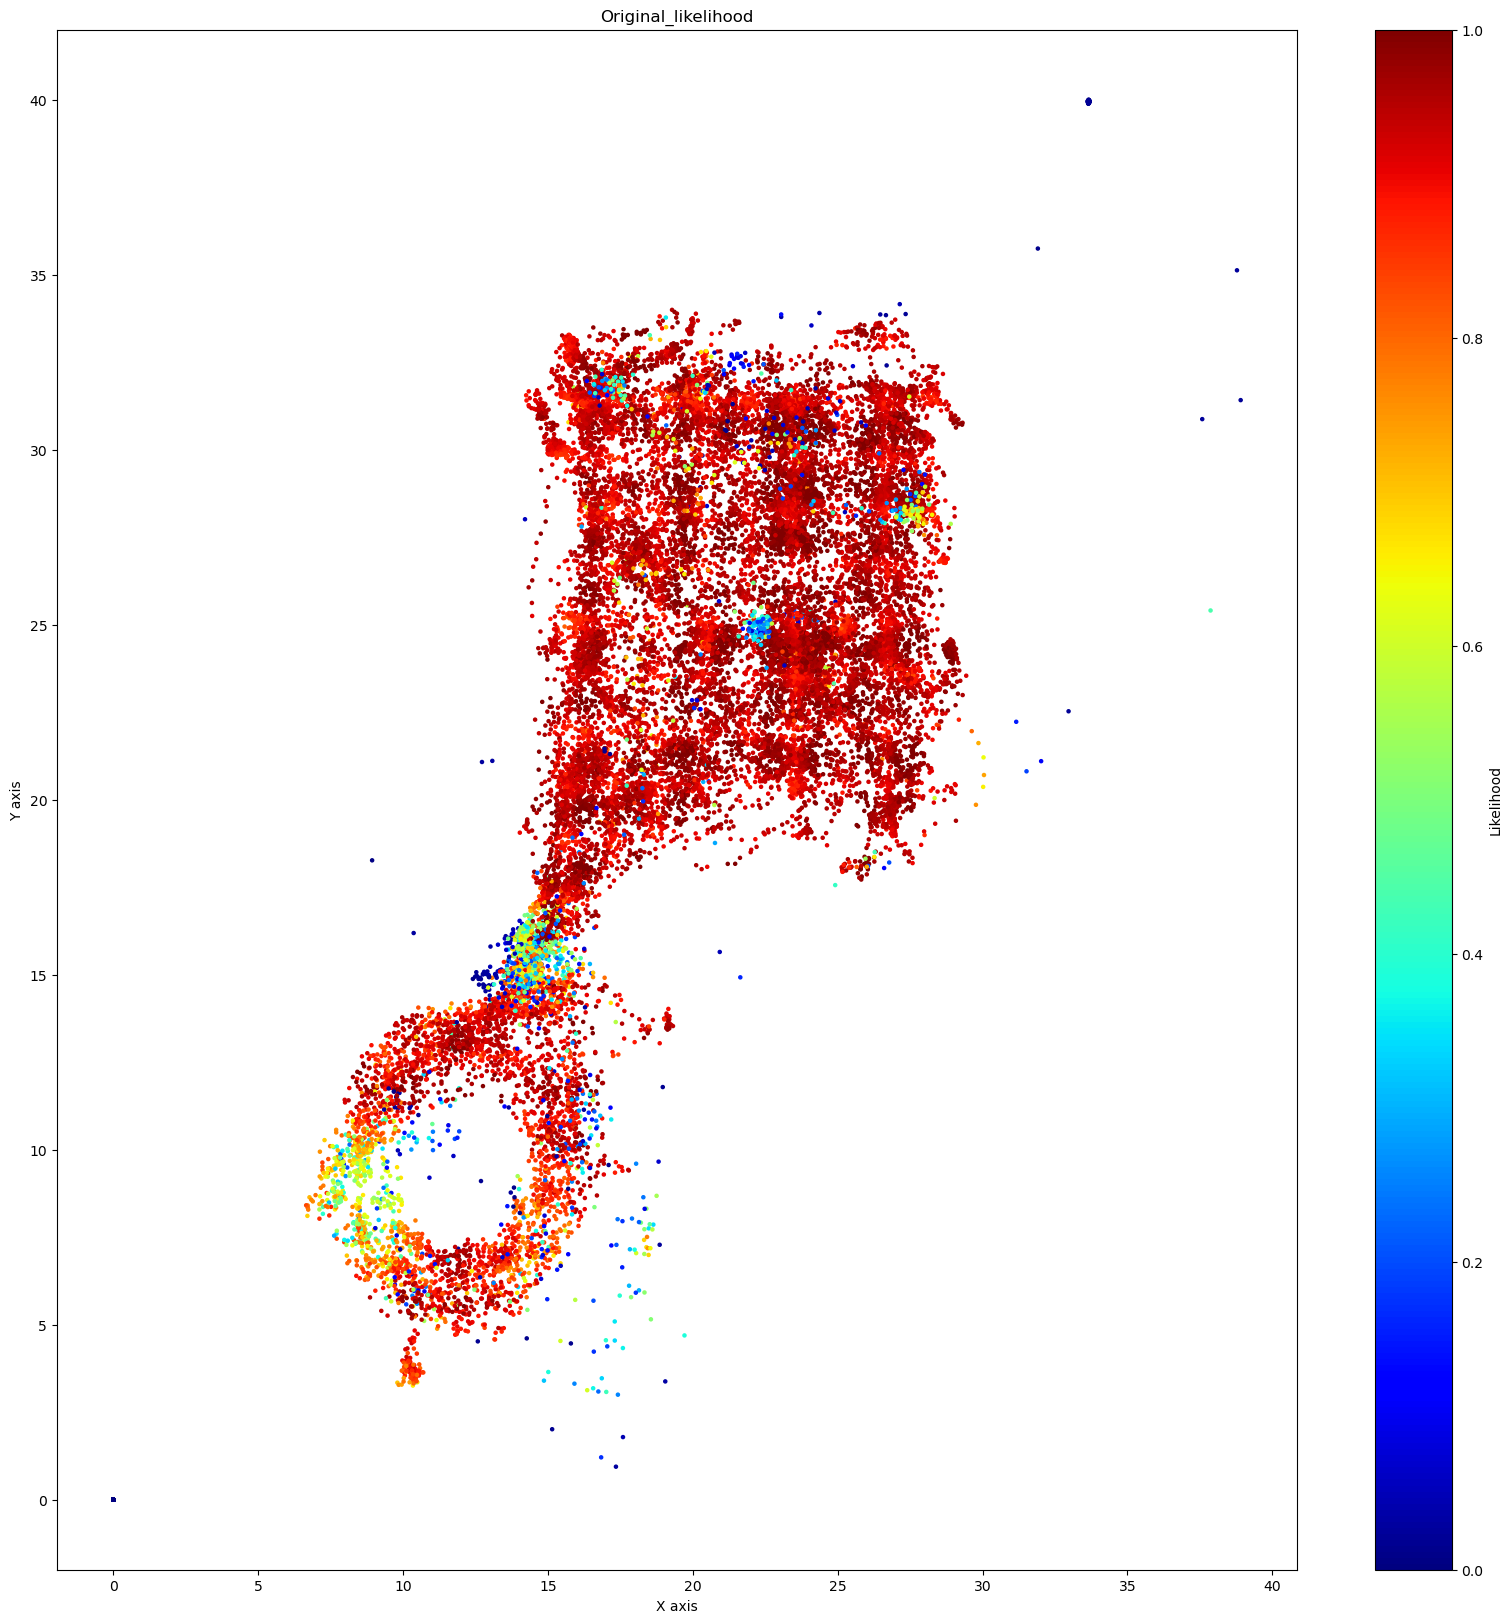

In [27]:
# Plot the likelihood scatter heatmap, trajectory and speed
plot_likelihood(df, 'Original_likelihood')
# plot_trajectory(df, 'Original_trajectory')

## Filtering & predict the coordinates with low likelihood

In [28]:
df = tag_likelihood(df, 0.6)
df = predict_coordinates(df, 10)

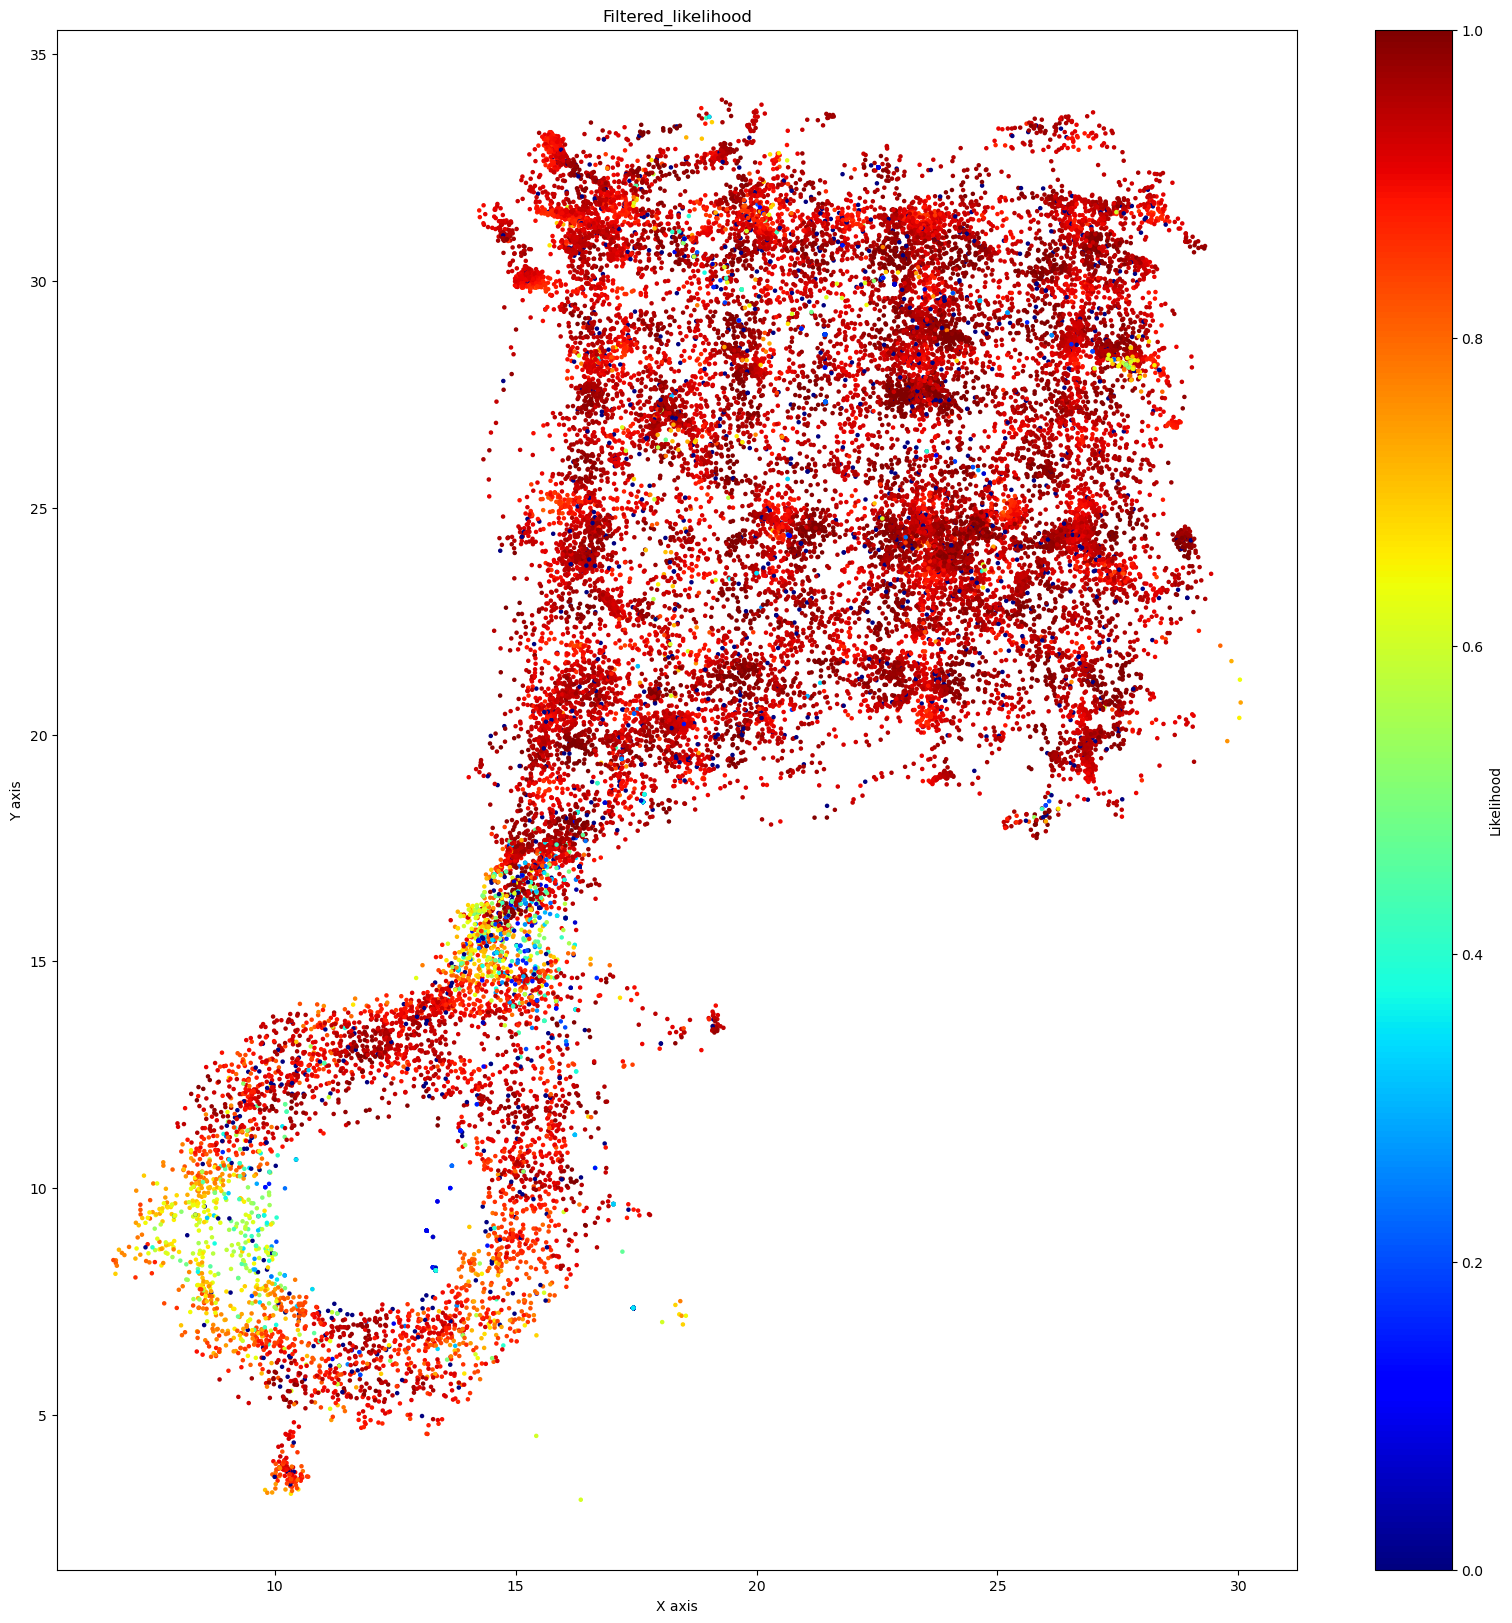

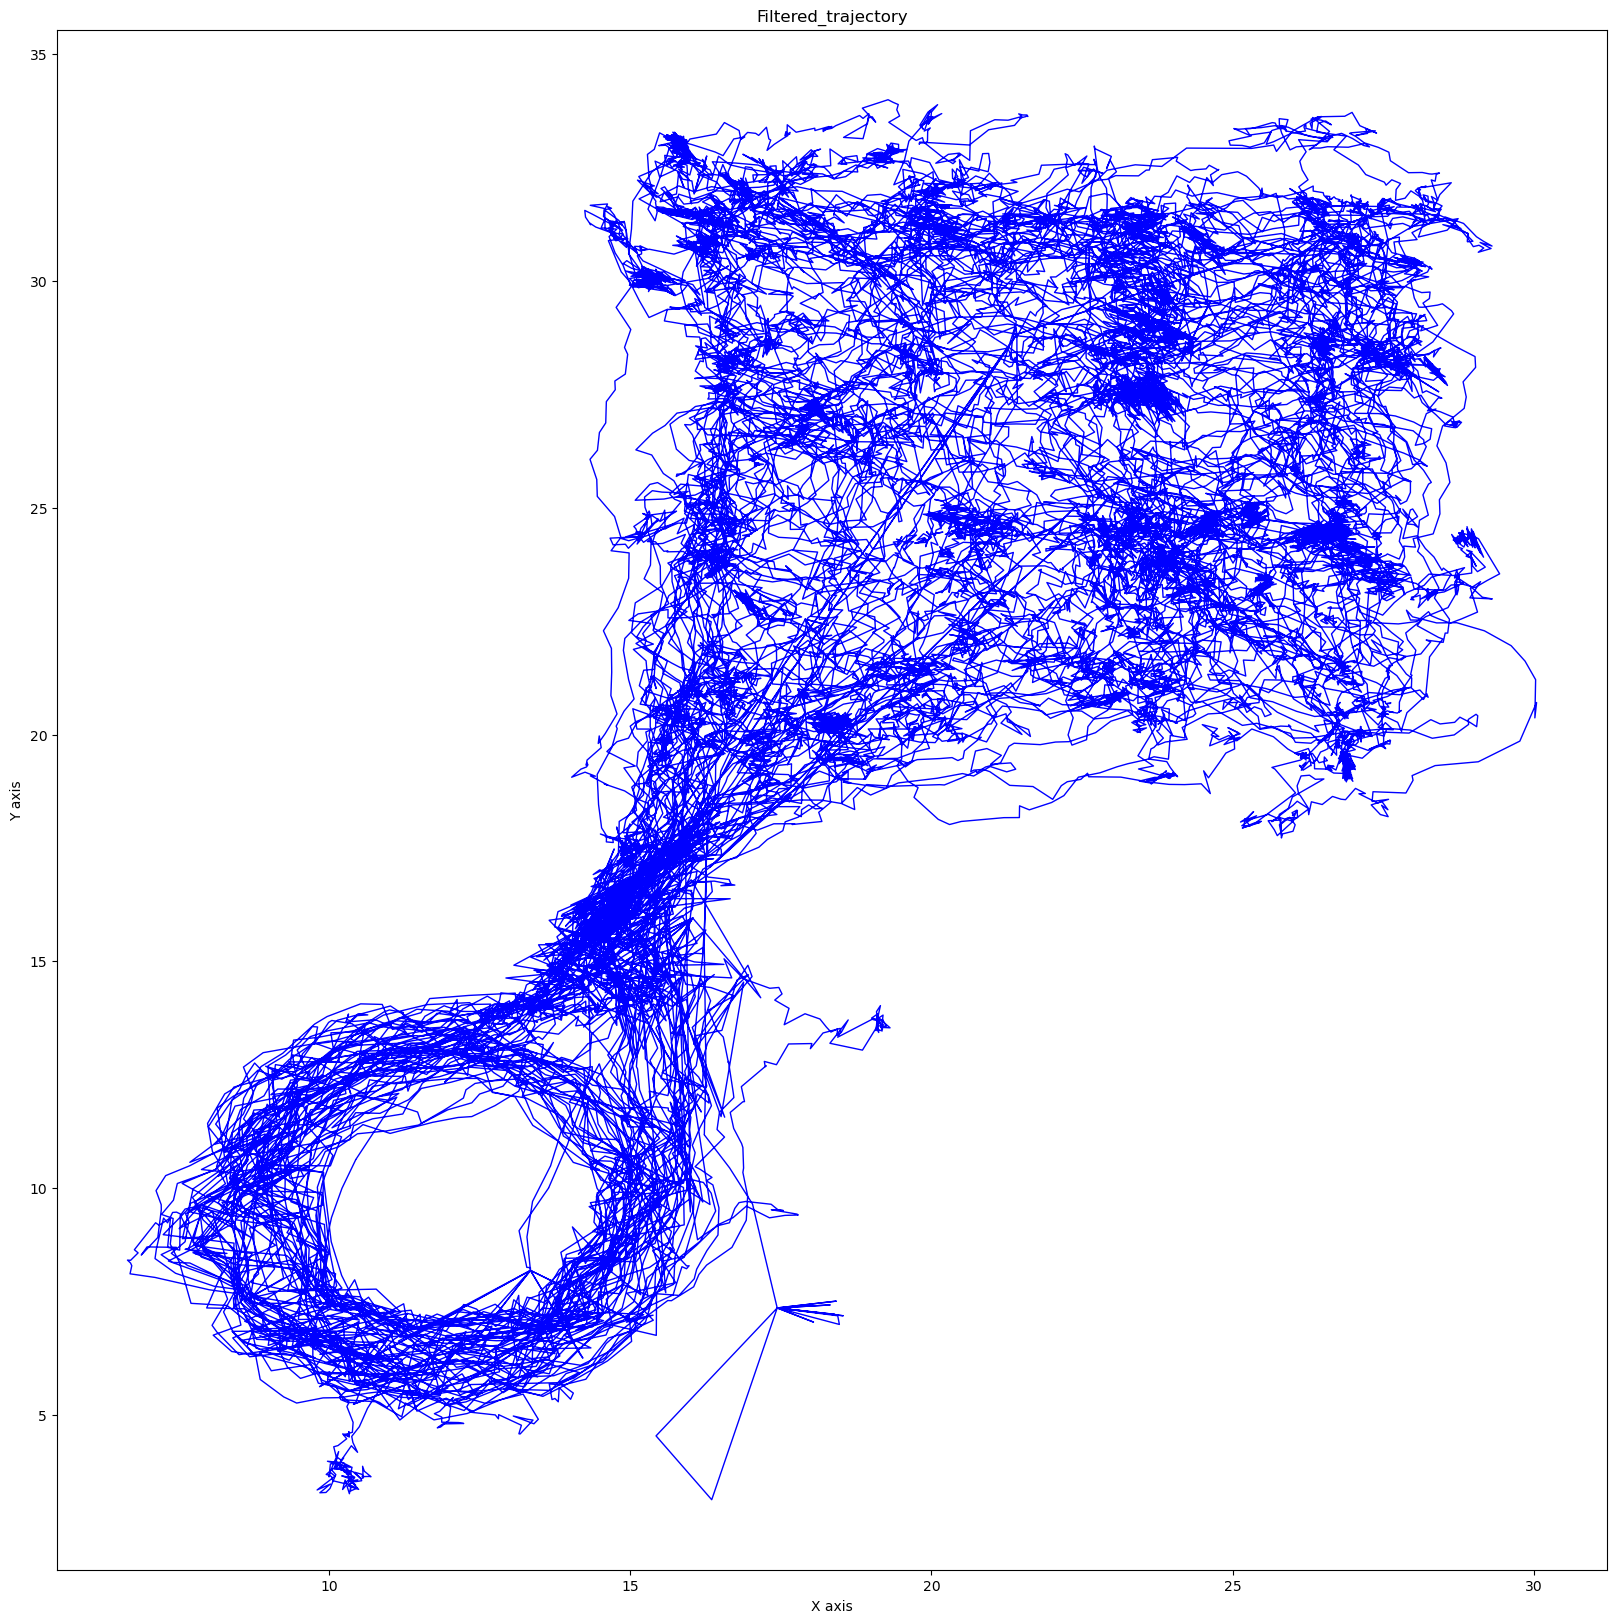

In [29]:
plot_likelihood(df, 'Filtered_likelihood')
plot_trajectory(df, 'Filtered_trajectory')

## Behavioral analysis and save

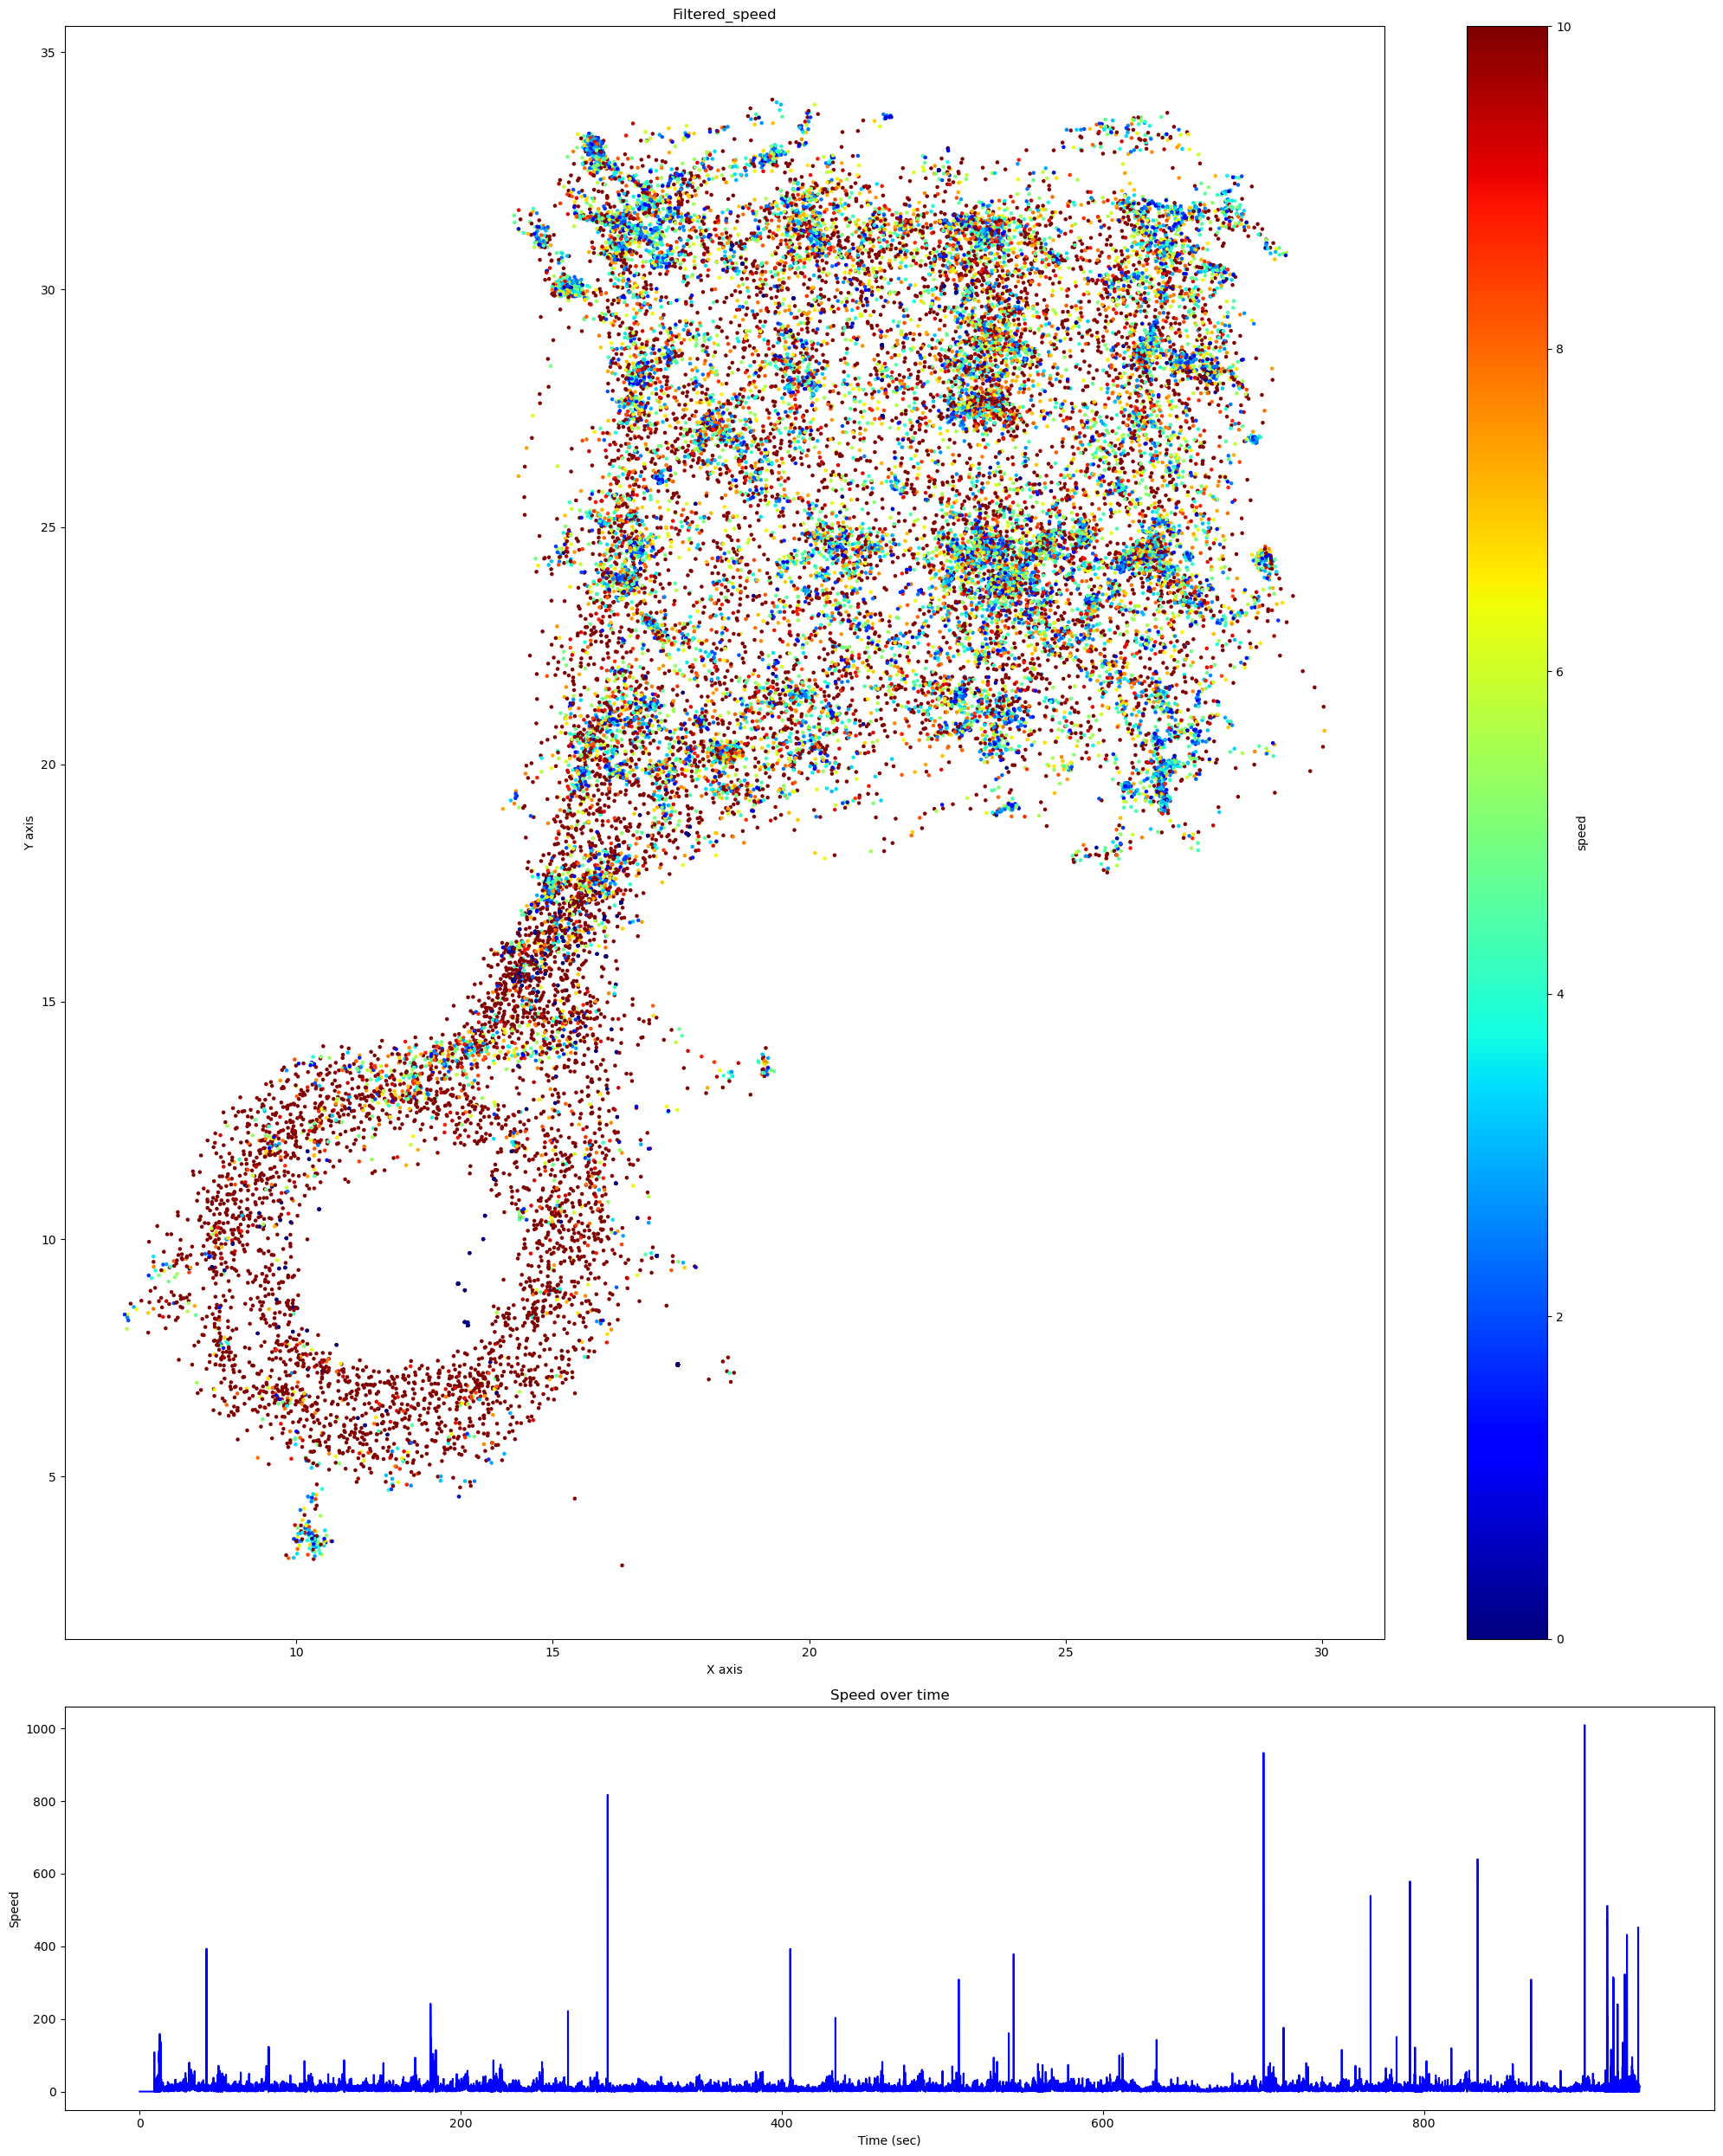

In [30]:
calc_speed_2D(df)
# df['isRunning'] = df['speed'] >= 1 # For Hai's project
plot_speed_2D(df, 'Filtered_speed')

In [32]:
# calc_speed_2D(df)
# df['isRunning'] = df['speed'] >= 1 # For Hai's project
# plot_speed_2D(df, 'Filtered_speed')
# plot_trajectory(df, 'Filtered_speed_trajectory')

In [33]:
df.to_csv ('behavior.csv', index = True )
df

camNum  frameNum  timeSec        xPix       yPix  likelihood  \
0         0.0       1.0    0.000  162.723720  182.32713    0.012735   
1         0.0       2.0    0.012  102.365715  151.74414    0.027578   
2         0.0       3.0    0.044  171.698870  203.85432    0.021763   
3         0.0       4.0    0.076  171.630280  203.76115    0.021003   
4         0.0      -1.0    0.092    0.000000    0.00000    0.000000   
...       ...       ...      ...         ...        ...         ...   
29041     0.0   27439.0  934.027  140.841500  143.03851    0.549838   
29042     0.0   27440.0  934.107  141.806640  143.14780    0.635405   
29043     0.0   27441.0  934.139  140.369430  143.52344    0.648612   
29044     0.0   27442.0  934.171  142.588320  142.18057    0.647322   
29045     0.0   27443.0  934.203  140.698880  144.08100    0.532514   

               x          y  toPredict      speed  
0      17.440154   7.357878        1.0   0.000000  
1      17.440154   7.357878        1.0   0.000000  
2      17.440154   7.357878        1.0   0.000000  
3      17.440154   7.357878        1.0   0.000000  
4      17.440154   7.357878        1.0   0.000000  
...          ...        ...        ...        ...  
29041  27.675070  28.157758        1.0   0.000000  
29042  27.805224  28.068843        0.0   1.970322  
29043  27.523418  28.142499        0.0   9.102275  
29044  27.958494  27.879185        0.0  15.892269  
29045  27.675070  28.157758        1.0  12.418955  

[29046 rows x 10 columns]